In [ ]:
# ! pip install python-gdcm
# ! pip install pylibjpeg pylibjpeg-libjpeg pydicom pylibjpeg-openjpeg

In [ ]:
# !wandb login --host=http://8.219.189.100:8081

In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
batch_size = 4
wd = 1e-5
pos_weight=20

In [3]:
wandb_entity='longyi'
model_name = "resblock"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
})
wandb.run.name = f'brief_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


In [4]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *
from utils.train_utils import *

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [6]:
DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")
XRAY_IMAGES_DIR = os.path.join(DATA_DIR, "xray_images")
SEG_IMAGES_DIR = os.path.join(DATA_DIR, "segmentation_images")

In [7]:
seg_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_segment_idx.csv')).set_index('StudyInstanceUID')
seg_df.head()

,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,
1.2.826.0.1.3680043.10633,1,428,314.099976
1.2.826.0.1.3680043.10633,2,427,313.599976
1.2.826.0.1.3680043.10633,3,426,313.099976
1.2.826.0.1.3680043.10633,4,425,312.599976
1.2.826.0.1.3680043.10633,5,424,312.099976


In [8]:
from utils.dcm_utils import read_dcm
from PIL import Image

class SegDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        slice_df = self.df.iloc[idx]
        UID = slice_df.name

        slice_img = read_dcm(os.path.join(TRAIN_IMAGES_DIR, UID), slice_df.InstanceNumber)
        slice_img = Image.fromarray(np.uint8(slice_img * 255), 'L')

        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{int(slice_df.seg_idx)}.png"))
        # label_img = np.round(np.asarray(label_img, np.uint8) // 32)
        if self.transform:
            slice_img, label_img = self.transform(slice_img, label_img)

        return slice_img, label_img

In [9]:
total_slices = np.arange(len(seg_df))
np.random.shuffle(total_slices)
train_indices, val_indices = total_slices[:-3000], total_slices[-3000:]
train_df = seg_df.iloc[train_indices]
val_df = seg_df.iloc[val_indices]
train_df.head()

,InstanceNumber,seg_idx,ImagePositionPatientZ
StudyInstanceUID,,,
1.2.826.0.1.3680043.27016,69,217,110.250
1.2.826.0.1.3680043.5002,319,80,83.500
1.2.826.0.1.3680043.12833,43,218,-147.000
1.2.826.0.1.3680043.5783,166,435,-66.608
1.2.826.0.1.3680043.24140,179,60,-609.400


In [10]:
class DataTransform(nn.Module):
    def __init__(self):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(256),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        self.target_transform = T.Compose([
            T.Resize(256),
            T.ToTensor(),
        ])

    def forward(self, x, y):
        x = self.transform(x)

        y = self.target_transform(y)
        y = y.gt(0).float()

        return x, y

transform = DataTransform()

In [11]:
train_dataset = SegDataset(train_df, TRAIN_IMAGES_DIR, SEG_IMAGES_DIR, transform=transform)
val_dataset = SegDataset(val_df, TRAIN_IMAGES_DIR, SEG_IMAGES_DIR, transform=transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Check small datasets

tensor(0.0380)


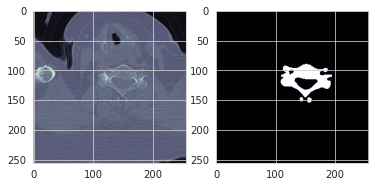

In [13]:

x, y = val_dataset[0]
_, axs = plt.subplots(1, 2)
axs[0].imshow(x.squeeze(), cmap='bone')
axs[1].imshow(y.squeeze(), cmap='bone')
print(y.mean())

In [14]:
print(x.min())
print(x.max())
print(y.min())
print(y.max())

tensor(-1.)
tensor(1.)
tensor(0.)
tensor(1.)


## Model

In [15]:
class ResidualBlock(nn.Module):
    def __init__(self, h):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, h, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, 2*h, kernel_size=1)
        )
    def forward(self, x):
        out = self.layers(x)
        out += x
        return out

class SegModel(nn.Module):
    def __init__(self, h, num_residual=8):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 2*h, kernel_size=3, padding='same'),
            *[
                ResidualBlock(h) for _ in range(num_residual)
            ],
            nn.ReLU(inplace=True),
            nn.Conv2d(2*h, 1, kernel_size=1)
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
model = SegModel(256, num_residual=8).to(device)

In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

6829569

In [19]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [20]:
def loss_fn(logits, y, pos_weight=10):
    loss = F.binary_cross_entropy_with_logits(logits, y, pos_weight=torch.tensor(pos_weight))
    return loss

In [21]:
def train_one_epoch(e, model, dataloader):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            loss = loss_fn(logits, y, pos_weight=pos_weight)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # optimizer.step()

        train_iter.set_description(f"t {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if i % 100 == 0:
            with torch.no_grad():
                inference(model, val_dataset)
            model.train()

        if wandb.run is not None:
            wandb.log({
                'train_loss' : loss.item(),
                'epoch' : e
            })

    return np.mean(losses)

In [22]:
def evaluate(e, model, dataloader):

    model.eval()
    eval_iter = tqdm(dataloader)
    losses = []

    for i, (x, y) in enumerate(eval_iter):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = loss_fn(logits, y, pos_weight=pos_weight)

        eval_iter.set_description(f"e {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss' : loss.item(),
                'epoch' : e
            })

    return np.mean(losses)

In [23]:
np.random.randint(10)

5

In [24]:
def inference(model, dataset, i=None):
    model.eval()
    if i is None:
        i = np.random.randint(len(dataset) -1)
    x, y = dataset[i]

    x = x.unsqueeze(0).to(device)
    logits = model(x)
    pred = logits.sigmoid().gt(0.5).float()

    img = x * 0.5 + 0.5

    if wandb.run is not None:
        wandb.log({
            'val_img' : wandb.Image(img.squeeze().cpu().numpy()),
            'val_pred' : wandb.Image(pred.squeeze().cpu().numpy()),
            'val_label' : wandb.Image(y.squeeze().cpu().numpy())
        })

    # _, axs = plt.subplots(1, 2)
    # axs[0].imshow(img.squeeze().cpu(), cmap='bone')
    # axs[1].imshow(pred.squeeze().cpu())

inference(model, val_dataset, 0)

In [25]:
epochs = 10

for epoch in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        eval_loss = evaluate(epoch, model, val_loader)
        inference(model, val_dataset)

    print(f"epoch {epoch} train_loss {train_loss} eval_loss {eval_loss}")

    # if wandb.run is not None:
    #     wandb.log({
    #         'average_train_loss' : train_loss,
    #         'average_eval_loss' : eval_loss,
    #     })

t 0 loss 0.5498:  13%|█▎        | 898/6708 [13:01<1:24:13,  1.15it/s]


KeyboardInterrupt: 